In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import classification_report, auc, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import cm

plt.style.use('../figures/journal-style.mplstyle')
def sort_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]
    return z

def remove_spines(axes):
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)
def hide_axes(axes):
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

In [56]:
triageData = pd.read_excel("../data/triageOutput/BEST3-validationOutput.xlsx")

triageData.sort_values(by=['Triage class'],inplace=True,ascending=True)        
#triageDataNoConf = triageData.loc[(triageData['DL-QC-L']==0)]
#triageDataHighConfDiag = triageData.loc[(triageData['DL-QC-H']==1)]

In [57]:
triageData['Triage class'].value_counts(sort=False)

0     66
1    204
2    477
3     41
4    370
5    236
6     65
7     60
Name: Triage class, dtype: int64

In [58]:
# Summarise triage class occurence BEST2
print(len(triageData))
triageData['Triage class'].value_counts(sort=False)/len(triageData)

1519


0    0.043450
1    0.134299
2    0.314022
3    0.026991
4    0.243581
5    0.155365
6    0.042791
7    0.039500
Name: Triage class, dtype: float64

In [59]:
triageData['Cytosponge'].value_counts()

0    1330
1     189
Name: Cytosponge, dtype: int64

0.9902255639097745 0.5608465608465608


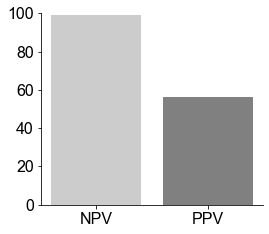

In [60]:
# Gradually replace everything with AI data and check sens/spec
triageDataCopy = triageData.copy(deep=True)
#triageDataCopy = triageDataCopy[(triageDataCopy['Triage class']!=0)]


tn, fp, fn, tp = confusion_matrix(triageDataCopy['BE (Trial)'], triageDataCopy['Cytosponge']).ravel()
pathologistSpecificityCS = tp / (tp+fp)
pathologistSensitivityCS = tn / (tn+fn)

print(pathologistSensitivityCS,pathologistSpecificityCS)

#triageDataCopy.loc[triageData['Triage class']==0, "Cytosponge"] = 0 

#tn, fp, fn, tp = confusion_matrix(triageDataCopy['Endoscopy (at least C1M3)'], triageDataCopy['Cytosponge']).ravel()
#pathologistSpecificity = tn / (tn+fp)
#pathologistSensitivity = tp / (tp+fn)

#print(pathologistSensitivity,pathologistSpecificity)

plt.figure(figsize=(4,3.5))

objects = ('NPV', 'PPV')
y_pos = np.arange(len(objects))
performance = [pathologistSensitivityCS*100,pathologistSpecificityCS*100]

plt.bar(y_pos, performance, align='center', alpha=1, color=[[.8,.8,.8],[.5,.5,.5]])

plt.xticks(y_pos, objects)
#plt.ylabel('[%]')
#plt.xlabel('Pathologist only',fontweight='bold')
plt.ylim(0,100)
#plt.title('Programming language usage')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#for i, v in enumerate(performance):
#    plt.text(y_pos[i]-0.2, v + 5, str(round(v,1))+'%')
plt.savefig('../figures/triageGraphics/BEST3-pathologistOnlySensSpec.pdf')

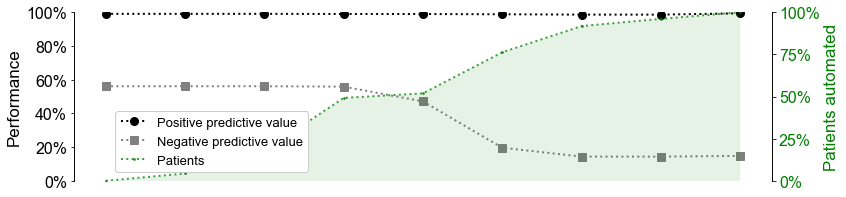

In [68]:
groups=('Path','0','0-1','0-2','0-3','0-4','0-5','0-6','0-7')
groupType = [0,0,0,1,1,1,1,1]
fig, ax1 = plt.subplots(figsize=(12,3))
ax2 = ax1.twinx()
incrementalSensitivities = [pathologistSensitivityCS*100]
incrementalSpecificities = [pathologistSpecificityCS*100]
patientCountAutomatedBO = [0]
for i in range(0,8):
    triageDataLowToHigh = triageData.copy(deep=True)
    #triageDataLowToHigh = triageDataLowToHigh[(triageDataLowToHigh['Triage class']!=0)]
    for k in range(0,i+1):
        #print(k)
        triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']==k, "Cytosponge"] = groupType[k]     
    patientCountAutomatedBO.append(len(triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']<=i]))
    tn, fp, fn, tp = confusion_matrix(triageDataLowToHigh['BE (Trial)'], triageDataLowToHigh['Cytosponge']).ravel()
    pathologistSpecificity = tp / (tp+fp)
    pathologistSensitivity = tn / (tn+fn)
    #print(i,pathologistSensitivity,pathologistSpecificity,patientCountAutomated)
    incrementalSensitivities.append(pathologistSensitivity*100)
    incrementalSpecificities.append(pathologistSpecificity*100)
    #print(triageDataLowToHigh['Cytosponge'].value_counts())
    
ax1.set_ylim(40,100)
ax2.set_ylim(0,len(triageData))
ax2.fill_between(groups, 0, patientCountAutomatedBO, facecolor="g", alpha=0.1)
ax1.plot(groups,incrementalSensitivities,linestyle=':',marker='o',color='black',markersize=8,label='Positive predictive value')
ax1.plot(groups,incrementalSpecificities,linestyle=':',marker='s',color='grey',markersize=8,label='Negative predictive value')
ax2.plot(groups,patientCountAutomatedBO,linestyle=':',marker='p',color='g',markersize=2,label='Patients',alpha=0.75)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Performance')
ax2.set_ylabel('Patients automated', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
ax2.set_yticks([0,len(triageData)*0.25,len(triageData)/2,len(triageData)*0.75,len(triageData)])
ax2.set_yticklabels(['0%','25%','50%','75%','100%'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper left',facecolor='white',framealpha=1,bbox_to_anchor=(0.05, -0.05, 0.5, 0.5))
ax1.get_xaxis().set_visible(False)
#plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/triageGraphics/BEST3-sensSpecCount-1-to-1-6.pdf')

In [69]:
fromLeftSens = incrementalSensitivities

In [70]:
fromLeftSpec = incrementalSpecificities

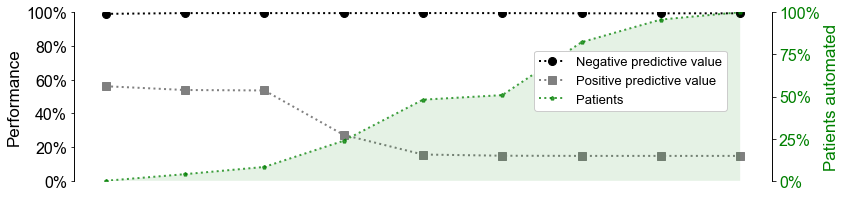

In [74]:
groups=('Path','0','0-1','0-2','0-3','0-4','0-5','0-6','0-7')
groupType = [0,0,0,1,1,1,1,1]
fig, ax1 = plt.subplots(figsize=(12,3))
ax2 = ax1.twinx()
incrementalSensitivities = [pathologistSensitivityCS*100]
incrementalSpecificities = [pathologistSpecificityCS*100]
patientCountAutomatedTD = []
for i in range(0,8):
    triageDataLowToHigh = triageData.copy(deep=True)
    #triageDataLowToHigh = triageDataLowToHigh[(triageDataLowToHigh['Triage class']!=0)]
    for k in range(0,i+1):
        #print(7-k-1)
        triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']==8-k-1, "Cytosponge"] = groupType[8-k-1]
    patientCountAutomatedTD.append(len(triageDataLowToHigh.loc[triageDataLowToHigh['Triage class']>=k]))
    tn, fp, fn, tp = confusion_matrix(triageDataLowToHigh['BE (Trial)'], triageDataLowToHigh['Cytosponge']).ravel()
    pathologistSpecificity = tp / (tp+fp)
    pathologistSensitivity = tn / (tn+fn)
    #print(i,pathologistSensitivity,pathologistSpecificity)
    incrementalSensitivities.append(pathologistSensitivity*100)
    incrementalSpecificities.append(pathologistSpecificity*100)

#incrementalSensitivities.reverse()
#incrementalSpecificities.reverse()
patientCountAutomatedTD.append(0)
patientCountAutomatedTD.reverse()
    
ax1.set_ylim(40,100)
ax2.set_ylim(0,len(triageData))
ax2.fill_between(groups, 0, patientCountAutomatedTD, facecolor="g", alpha=0.1)
ax1.plot(groups,incrementalSensitivities,linestyle=':',marker='o',color='black',markersize=8,label='Negative predictive value')
ax1.plot(groups,incrementalSpecificities,linestyle=':',marker='s',color='grey',markersize=8,label='Positive predictive value')
ax2.plot(groups,patientCountAutomatedTD,linestyle=':',marker='p',color='g',markersize=4,label='Patients',alpha=0.75)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Performance')
ax2.set_ylabel('Patients automated', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
ax2.set_yticks([0,len(triageData)*0.25,len(triageData)/2,len(triageData)*0.75,len(triageData)])
ax2.set_yticklabels(['0%','25%','50%','75%','100%'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower left',facecolor='white',framealpha=1,bbox_to_anchor=(0.65, 0.375, 0.5, 0.5))
ax1.get_xaxis().set_visible(False)
plt.savefig('../figures/triageGraphics/BEST3-sensSpecCount-1-6-to-6.pdf')

In [45]:
fromRightSens = incrementalSensitivities

In [46]:
fromRightSpec = incrementalSpecificities

In [52]:
fromRightSens.reverse()
fromRightSpec.reverse()

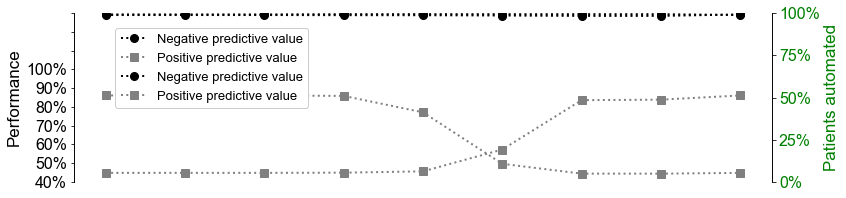

In [54]:
groups=('Path','0','0-1','0-2','0-3','0-4','0-5','0-6','0-7')
groupType = [0,0,0,1,1,1,1,1]
fig, ax1 = plt.subplots(figsize=(12,3))
ax2 = ax1.twinx()

    
ax1.set_ylim(40,100)
ax2.set_ylim(0,len(triageData))
ax1.plot(groups,fromLeftSens,linestyle=':',marker='o',color='black',markersize=8,label='Negative predictive value')
ax1.plot(groups,fromLeftSpec,linestyle=':',marker='s',color='grey',markersize=8,label='Positive predictive value')

ax1.plot(groups,fromRightSens,linestyle=':',marker='o',color='black',markersize=8,label='Negative predictive value')
ax1.plot(groups,fromRightSpec,linestyle=':',marker='s',color='grey',markersize=8,label='Positive predictive value')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Performance')
ax2.set_ylabel('Patients automated', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.set_yticks([10,20,30,40,50,60,70,80,90,100])
ax1.set_yticklabels(['40%','50%','60%','70%','80%','90%','100%'])
ax2.set_yticks([0,len(triageData)*0.25,len(triageData)/2,len(triageData)*0.75,len(triageData)])
ax2.set_yticklabels(['0%','25%','50%','75%','100%'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower left',facecolor='white',framealpha=1,bbox_to_anchor=(0.05, 0.4, 0.5, 0.5))
ax1.get_xaxis().set_visible(False)
plt.savefig('../figures/triageGraphics/BEST3-combined-sens-spec.pdf')

In [47]:
groupTypeReplace = [1,1,1,0,0,0,1,1]
groupType = [0,0,0,1,1,1,1,1]
patientCountAutomated = 0
triageDataEndModel = triageData.copy(deep=True)
for i in range(0,8):
    #print(i)
    if groupTypeReplace[i] is 1:
        print(i,groupType[i])
        triageDataEndModel.loc[triageDataEndModel['Triage class']==i, "Cytosponge"] = groupType[i]
        patientCountAutomated += len(triageDataEndModel.loc[triageDataEndModel['Triage class']==i])
tn, fp, fn, tp = confusion_matrix(triageDataEndModel['BE (Trial)'], triageDataEndModel['Cytosponge']).ravel()
print(triageDataEndModel['Cytosponge'].value_counts())
pathologistSpecificity = tp / (tp+fp)
pathologistSensitivity = tn / (tn+fn)
#print(i,pathologistSensitivity,pathologistSpecificity)
print(pathologistSensitivity*100)
print(pathologistSpecificity*100)
print(patientCountAutomated,len(triageData),str(round(patientCountAutomated/len(triageData)*100,2)) + '%')



0 0
1 0
2 0
6 1
7 1
0    1311
1     208
Name: Cytosponge, dtype: int64
99.38977879481313
53.36538461538461
872 1519 57.41%


<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-47-4ce47756a913>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupTypeReplace[i] is 1:


In [48]:
len(triageData.loc[(triageData['Triage class']==6) & (triageData['Cytosponge']==0) & (triageData['BE (Trial)']==1)])

0

In [49]:
triageData['Cytosponge'].value_counts()

0    1330
1     189
Name: Cytosponge, dtype: int64

In [50]:
triageData['BE (Trial)'].loc[(triageData['DL-Diag-L']==0) & (triageData['DL-Diag-H']==0)].value_counts()

0    742
1      5
Name: BE (Trial), dtype: int64